<a href="https://colab.research.google.com/github/ntontonto/kaggle/blob/mitty_branch/house-prices/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 特徴量のカンペはこちら ⇒ https://docs.google.com/spreadsheets/d/1T59ieP110cFg8MfOtIbW2M60iWuSwnIf/edit?usp=share_link&ouid=111727008586725963366&rtpof=true&sd=true

## Kaggle用データのインポート

In [1]:
from google.colab import drive
drive.mount('/content/drive')

COMPETITION = "house-prices-advanced-regression-techniques"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle"

import os

if not(os.path.exists(WORK_DIR)):
  os.mkdir(WORK_DIR)
os.chdir(WORK_DIR)

from google.colab import files
files.upload()

Mounted at /content/drive


{}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c {COMPETITION} # copy from competition page!
!unzip -o {COMPETITION}
!rm {COMPETITION}.zip

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open house-prices-advanced-regression-techniques, house-prices-advanced-regression-techniques.zip or house-prices-advanced-regression-techniques.ZIP.
rm: cannot remove 'house-prices-advanced-regression-techniques.zip': No such file or directory


## ライブラリのインポート

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from numpy import mean, std

import statsmodels.formula.api as smf
from statsmodels.stats import power
import statsmodels.api as sm
from scipy import stats
import math
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE) # seabornのデフォルトの色を変更する
BACKCOLOR = '#f6f5f5'

from scipy.special import boxcox1p
from IPython.core.display import HTML
from scipy.stats import norm, skew #for some statistics
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedKFold
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from copy import deepcopy

### User modules

In [3]:
# 並び替え検定用の関数
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

In [4]:
# permutation test
def permutation_test(data, var, target):

  vA = data[var].dropna().unique()[0]
  vB = data[var].dropna().unique()[1]
  mean_a = data[data[var] == vA][target].mean()
  mean_b = data[data[var] == vB][target].mean()
  print(f"{target} mean value with {var}={vA}: {mean_a}")
  print(f"{target} mean value with {var}={vB}: {mean_b}")
  print(f"{target} observed difference between ({var}={vA}) and ({var}={vB}): {mean_b - mean_a}")
  nA = data[data[var] == vA].shape[0]
  nB = data[data[var] == vB].shape[0]

  random.seed(1)
  perm_diffs = pd.Series([perm_fun(data[target], nA, nB) for _ in range(1000)])
  perm_diffs = perm_diffs.dropna()

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.hist(perm_diffs, bins=11, rwidth=0.9)
  ax.axvline(x = mean_b - mean_a, color='black', lw=2)
  ax.text(mean_b - mean_a, 10, 'Observed\ndifference', bbox={'facecolor':'white'})
  ax.set_xlabel(f'{var} differences')
  ax.set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

  perm_diffs = np.array(perm_diffs)
  print('p-value: ', (np.mean(perm_diffs > mean_b - mean_a)))

In [5]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [6]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

In [7]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=train, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

In [8]:
# ANOVA using permutation test
# Image size が ～～～ のエラーが出た場合は logx = True に設定する
def anova_perm(data, var, target, logx=False):

  # Creating crosstab
  crosstb = pd.crosstab(data[var], data[target])

  # Creating barplot
  # pl = crosstb.plot(kind="bar", stacked=True, rot=0)

  for col in data[var].unique():
      try:
          true_ratio = len(data[(data[var]==col)&(data[target]==True)]) / len(data[data[var]==col])
      except:
          break
      print(col, true_ratio)

  observed_variance = data.groupby(var).mean().var()[target] # グループごとの平均値を求め、その平均値の分散を計算している
  print('Observed means:', data.groupby(var).mean()[target].values.ravel()) # ravel: 横方向の1次元のベクトルを返す
  print('Variance:', observed_variance)
  # Permutation test example with stickiness
  def perm_test(data):
      data = data.copy()
      data[target] = np.random.permutation(data[target].values)
      return data.groupby(var).mean().var()[target]

  random.seed(1)
  perm_variance = [perm_test(data) for _ in range(3000)]
  print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

  if logx == True:
    # 横長のグラフになってしまうので自然対数を取った（通常は下記2行は不要）
    observed_variance_log = np.log(observed_variance)
    perm_variance_log = np.log(perm_variance)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance_log, bins=11, rwidth=0.9)

    # 横長のグラフになってしまうので自然対数を取った（通常はxにobserved_varianceを指定）
    ax.axvline(x = observed_variance_log, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance, bins=11, rwidth=0.9)

    ax.axvline(x = observed_variance, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [9]:
# column_transformer 利用後のカラム名を取得する関数
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'): ## hasattrは引数がメソッドやプロパティであった場合にTrueを返す
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names
# get_feature_names(preprocessor)

In [10]:
def scatter_hist(data, xlabel, ylabel):
  x = data[xlabel]
  y = data[ylabel]

  fig = plt.figure(figsize=(8,8))
  gs = gridspec.GridSpec(3, 3)
  ax_main = plt.subplot(gs[1:3, :2])
  ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
  ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

  ax_main.scatter(x,y,marker='.')
  ax_main.set(xlabel=xlabel, ylabel=ylabel)

  ax_xDist.hist(x,bins=100,align='mid')
  ax_xDist.set(ylabel='count')
  ax_xCumDist = ax_xDist.twinx()
  ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
  ax_xCumDist.tick_params('y', colors='r')
  ax_xCumDist.set_ylabel('cumulative',color='r')

  ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
  ax_yDist.set(xlabel='count')
  ax_yCumDist = ax_yDist.twiny()
  ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
  ax_yCumDist.tick_params('x', colors='r')
  ax_yCumDist.set_xlabel('cumulative',color='r')

  plt.show()

## データのダウンロード

In [11]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

In [12]:
print(f'\033[32mtrain size : {train.shape[0]} x {train.shape[1]}')
print(f'\033[32mtest size : {test.shape[0]} x {test.shape[1]}')
print(f'\033[32mtotal size : {all_data.shape[0]} x {all_data.shape[1]}')

train size : 1460 x 81
test size : 1459 x 80
total size : 2919 x 81


## カテゴリ変数の定義

### 量的変数、カテゴリ変数の定義
自動で数的変数、カテゴリ変数、名義尺度 等を判別する

In [13]:
categorical_cols = []
numerical_cols = []
for i in all_data.columns.tolist():
    if all_data[i].dtype=='object':
        categorical_cols.append(i)
    else:
        numerical_cols.append(i)
print('Number of categorical features:', str(len(categorical_cols)))
print('Number of numerical features:', str(len(numerical_cols)))

Number of categorical features: 43
Number of numerical features: 38


# データの概形確認

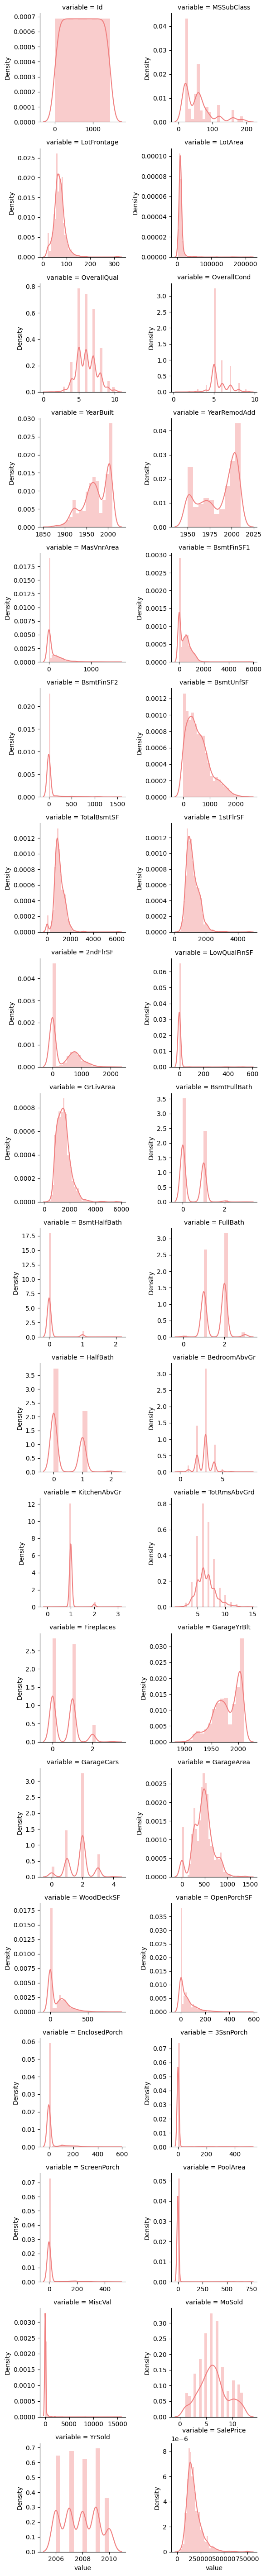

In [14]:
f = pd.melt(train, value_vars=numerical_cols)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

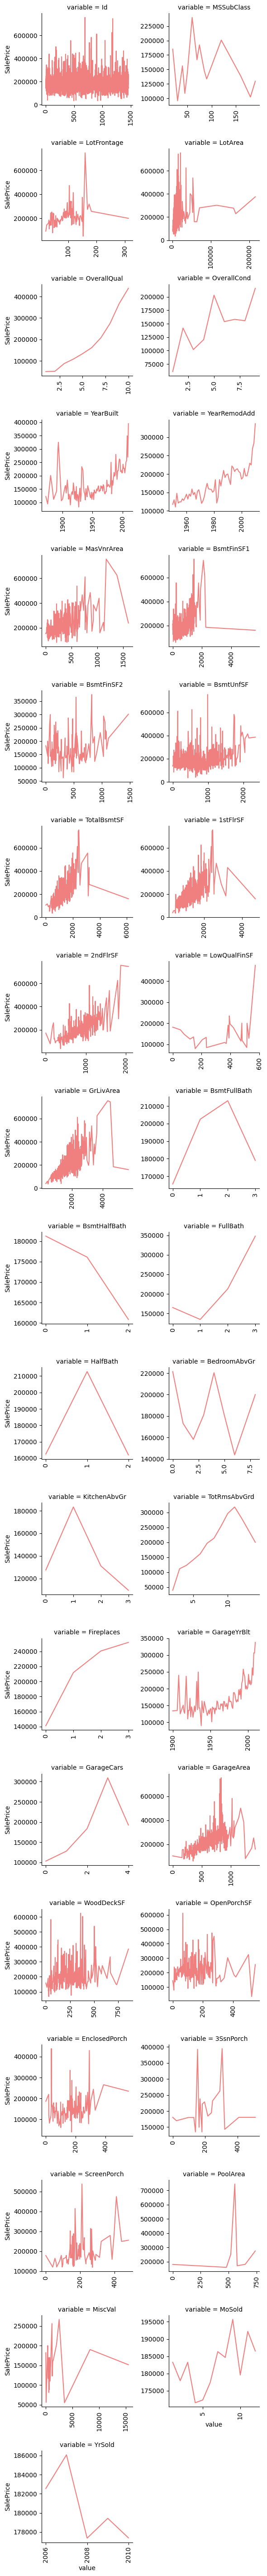

In [15]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)

f = pd.melt(train, id_vars=['SalePrice'], value_vars= numerical_cols)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(pairplot, "value", "SalePrice")

## zscoreを使ったハズレ値

In [16]:

def Zscore_outlier(df):
    out=[]
    m = np.mean(df)
    sd = np.std(df)
    for i in df:
        z = (i-m)/sd
        if np.abs(z) > 3:
            out.append(i)
    print("Outliers:",out)
Zscore_outlier(train['LotArea'])

Outliers: [50271, 159000, 215245, 164660, 53107, 70761, 53227, 46589, 115149, 53504, 45600, 63887, 57200]


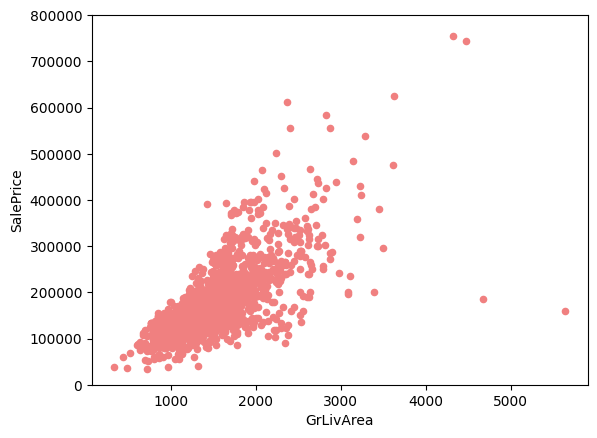

In [17]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [18]:
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

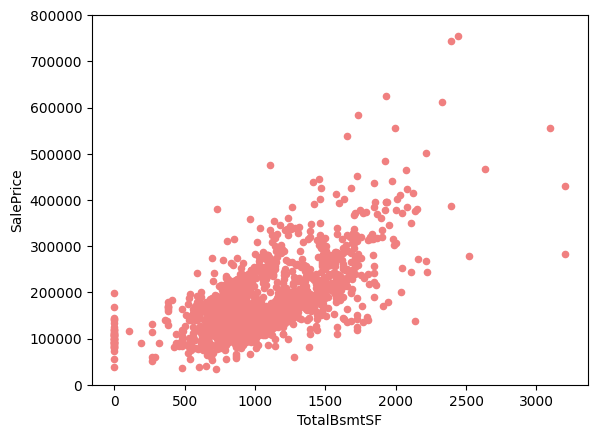

In [19]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

## 欠損値の確認

<Axes: >

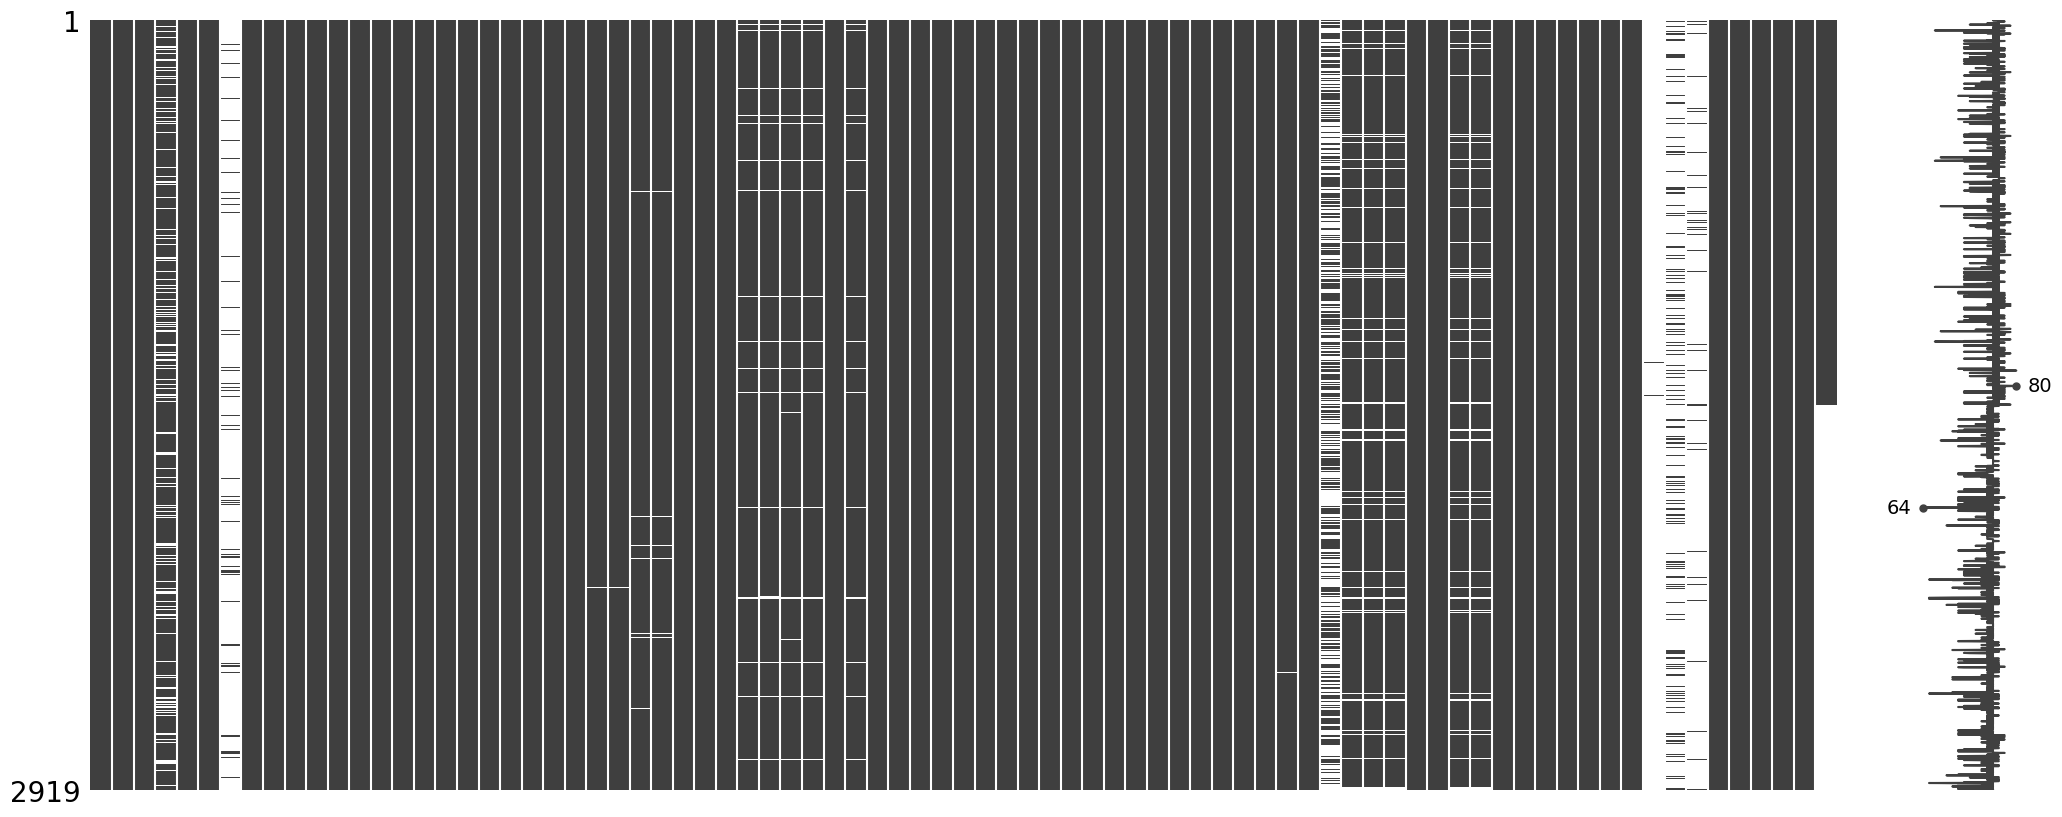

In [20]:
msno.matrix(all_data)

# 現時点でのスコアを確認する（0.13489）

In [21]:
all_data = pd.concat([train, test], axis=0)

### categorical や numerical の定義

In [22]:
target = "SalePrice"
feature_cols = all_data.columns.drop(target)

all_data["MSSubClass"] = all_data["MSSubClass"].astype("object")

categorical_cols = []
numerical_cols = []
for i in feature_cols:
    if all_data[i].dtype=='object':
        categorical_cols.append(i)
    else:
        numerical_cols.append(i)

print('Number of categorical features:', str(len(categorical_cols)))
print('Number of numerical features:', str(len(numerical_cols)))
print(categorical_cols)
print(numerical_cols)

Number of categorical features: 44
Number of numerical features: 36
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'Gara

In [23]:
def get_num_cat_column_names(df, target):
  feature_cols = df.columns.drop(target)
  categorical_cols = []
  numerical_cols = []
  for i in feature_cols:
      if df[i].dtype=='object':
          categorical_cols.append(i)
      else:
          numerical_cols.append(i)

  return categorical_cols, numerical_cols

### BoxCox変換する特徴量を決める

In [24]:
# Check the skew of all numerical features
skewed_feats = all_data[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[skewness.abs() > 0.75]
skewness.dropna(inplace=True)
skewed_features = skewness.index.copy()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


Skew in numerical features: 

There are 19 skewed numerical features to Box Cox transform


In [25]:
def get_skewed_column_names(df, numerical_cols):
  skewed_feats = df[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
  skewness = pd.DataFrame({'Skew' :skewed_feats})
  skewness = skewness[skewness.abs() > 0.75]
  skewness.dropna(inplace=True)
  skewed_features = skewness.index.copy()

  new_numerical_cols = numerical_cols.copy()
  for col in skewed_features:
    new_numerical_cols.remove(col)

  return skewed_features, new_numerical_cols

### Preprocessor

In [27]:
# 量的変数の前処理
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("power", PowerTransformer(method='yeo-johnson'))])

# カテゴリ変数の前処理
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder())])

# ColumnTransformerの作成
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

In [28]:
all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data), columns=get_feature_names(preprocessor))
all_data_preprocessed

,num__GarageYrBlt,num__Id,num__GarageArea,num__YearBuilt,num__MoSold,num__OverallQual,num__TotalBsmtSF,num__HalfBath,num__BsmtFullBath,num__BedroomAbvGr,...,skew__BsmtHalfBath,skew__MasVnrArea,skew__OpenPorchSF,skew__WoodDeckSF,skew__1stFlrSF,skew__LotFrontage,skew__GrLivArea,skew__BsmtFinSF1,skew__BsmtUnfSF,skew__2ndFlrSF
0,0.999898,-1.731687,0.352314,1.047231,-1.553332,0.649580,-0.450640,1.233664,1.090257,0.169987,...,-0.252630,1.261195,0.747138,-0.895923,-0.808773,-0.117681,0.587999,0.794909,-1.050097,1.262903
1,-0.086142,-1.730501,-0.057852,0.155606,-0.447384,-0.061424,0.495835,-0.755611,-0.818675,0.169987,...,3.958355,-0.760015,-0.991556,1.492209,0.461349,0.598047,-0.384666,1.219185,-0.573860,-0.844004
2,0.919450,-1.729314,0.631972,0.981185,1.027214,0.649580,-0.301442,1.233664,1.090257,0.169987,...,-0.252630,1.125735,0.392678,-0.895923,-0.571521,0.035054,0.720082,0.359519,-0.105838,1.275773
3,0.798779,-1.728128,0.790445,-1.858805,-1.553332,0.649580,-0.683762,-0.755611,1.090257,0.169987,...,-0.252630,-0.760015,0.223347,-0.895923,-0.426296,-0.382827,0.600455,-0.379876,0.180389,1.150512
4,0.879227,-1.726941,1.694675,0.948161,2.133162,1.360583,0.223082,1.233664,1.090257,1.385311,...,-0.252630,1.593052,1.041103,1.103598,0.155121,0.772605,1.343892,0.703308,0.050169,1.455994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,0.034529,1.726049,-2.201901,-0.042533,-0.078735,-1.483430,-1.173318,1.233664,-0.818675,0.169987,...,-0.252630,-0.760015,-0.991556,-0.895923,-2.124975,-2.779880,-0.851639,-1.147477,0.195425,0.851870
2913,-0.327485,1.727235,-0.868862,-0.042533,-0.816033,-1.483430,-1.173318,1.233664,-0.818675,0.169987,...,-0.252630,-0.760015,-0.090267,-0.895923,-2.124975,-2.779880,-0.851639,-0.266595,-0.540469,0.851870
2914,-0.729722,1.728422,0.482821,-0.372764,1.027214,-0.772427,0.407248,-0.755611,1.090257,1.385311,...,-0.252630,-0.760015,-0.991556,1.879608,0.366759,3.527041,-0.484740,1.537602,-1.644154,-0.844004
2915,0.034529,1.729608,-2.201901,0.683976,0.289915,-0.772427,-0.320092,-0.755611,-0.818675,0.169987,...,3.958355,-0.760015,0.143686,0.309266,-0.395145,-0.275269,-1.215908,-0.016611,0.266284,-0.844004


### Define Pipeline

In [29]:
all_data_preprocessed["cat__Electrical"]

0       4.0
1       4.0
2       4.0
3       4.0
4       4.0
       ... 
2912    4.0
2913    4.0
2914    4.0
2915    4.0
2916    4.0
Name: cat__Electrical, Length: 2917, dtype: float64

In [29]:
model = lgb.LGBMRegressor(objective='regression', num_leaves=4,learning_rate=0.01, n_estimators=6000,
                          max_bin=200, bagging_fraction=0.75,bagging_freq=5, bagging_seed=7,
                          feature_fraction=0.2,feature_fraction_seed=7,verbose=-1)
pipe = Pipeline(steps=[('preprocessor',preprocessor),('model',model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GarageYrBlt', 'Id',
                                                   'GarageArea', 'YearBuilt',
                                                   'MoSold', 'OverallQual',
                                                   'TotalBsmtSF', 'HalfBath',
                                                   'BsmtFullBath',
                                                   'BedroomAbvGr', 'GarageCars',
                                                   'TotRmsAbvGrd',
                                                   'OverallCond', 'FullBath',
                                                   'YearRem...
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', '1stFlrSF',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', '2ndFlrSF'],
      dtype='object'))])),
                ('model',
                 LGBMRegressor(bagging_fraction=0.75, bagging_freq=5,
                               bagging_seed=7, feature_fraction=0.2,
                               feature_fraction_seed=7, learning_rate=0.01,
                               max_bin=200, n_estimators=6000, num_leaves=4,
                               objective='regression', verbose=-1))])

In [30]:
# preprocessor を Pipelineに含めて Cross_validateするとエラーになるので、先に全データに対してPreprocessorをかける
all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data[target])

In [31]:
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor(objective='regression', num_leaves=4,learning_rate=0.01, n_estimators=6000,
                          max_bin=200, bagging_fraction=0.75,bagging_freq=5, bagging_seed=7,
                          feature_fraction=0.2,feature_fraction_seed=7,verbose=-1)

scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
score_mean = mean(scores["test_score"])
print(f"score:{score_mean}")
original_score = score_mean

score:-23476.703882595622


In [37]:
train_y

,SalePrice
0,2.583824
1,2.573300
2,2.589054
3,2.553297
4,2.597433
...,...
1453,2.570514
1454,2.584365
1455,2.602181
1456,2.554469


In [39]:
train_X

,num__BsmtFullBath,num__GarageArea,num__Fireplaces,num__GarageYrBlt,num__OverallQual,num__HalfBath,num__BedroomAbvGr,num__MoSold,num__TotalBsmtSF,num__OverallCond,...,skew__BsmtHalfBath,skew__MasVnrArea,skew__OpenPorchSF,skew__WoodDeckSF,skew__1stFlrSF,skew__LotFrontage,skew__GrLivArea,skew__BsmtFinSF1,skew__BsmtUnfSF,skew__2ndFlrSF
0,1.090257,0.352314,-0.924763,0.999898,0.649580,1.233664,0.169987,-1.553332,-0.450640,-0.507503,...,-0.252630,1.261195,0.747138,-0.895923,-0.808773,-0.117681,0.587999,0.794909,-1.050097,1.262903
1,-0.818675,-0.057852,0.626435,-0.086142,-0.061424,-0.755611,0.169987,-0.447384,0.495835,2.187374,...,3.958355,-0.760015,-0.991556,1.492209,0.461349,0.598047,-0.384666,1.219185,-0.573860,-0.844004
2,1.090257,0.631972,0.626435,0.919450,0.649580,1.233664,0.169987,1.027214,-0.301442,-0.507503,...,-0.252630,1.125735,0.392678,-0.895923,-0.571521,0.035054,0.720082,0.359519,-0.105838,1.275773
3,1.090257,0.790445,0.626435,0.798779,0.649580,-0.755611,0.169987,-1.553332,-0.683762,-0.507503,...,-0.252630,-0.760015,0.223347,-0.895923,-0.426296,-0.382827,0.600455,-0.379876,0.180389,1.150512
4,1.090257,1.694675,0.626435,0.879227,1.360583,1.233664,1.385311,2.133162,0.223082,-0.507503,...,-0.252630,1.593052,1.041103,1.103598,0.155121,0.772605,1.343892,0.703308,0.050169,1.455994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,-0.818675,-0.057852,0.626435,0.839003,-0.061424,1.233664,0.169987,0.658564,-0.224512,-0.507503,...,-0.252630,-0.760015,0.346623,-0.895923,-0.454208,-0.275269,0.472964,-1.147477,0.999162,1.071710
1454,1.090257,0.128587,2.177633,-0.005695,-0.061424,-0.755611,0.169987,-1.553332,1.148576,0.390790,...,-0.252630,0.882070,-0.991556,1.627090,1.927908,0.815441,1.168072,0.936371,0.299446,-0.844004
1455,-0.818675,-1.027335,2.177633,-1.493972,0.649580,-0.755611,1.385311,-0.447384,0.239401,3.085667,...,-0.252630,-0.760015,0.731613,-0.895923,0.273051,-0.066208,1.532686,-0.196503,0.872669,1.538648
1456,1.090257,-1.083267,-0.924763,-1.131959,-0.772427,-0.755611,-1.045337,-0.816033,0.066890,0.390790,...,-0.252630,-0.760015,-0.991556,1.667114,-0.042644,0.035054,-0.892245,-0.960495,-1.644154,-0.844004


In [ ]:
from sklearn.model_selection import validation_curve
scoring = 'neg_root_mean_squared_error'  # 評価指標をRMSEに指定
fit_params =
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(parameters.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X_train, y=y_train,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
cv_params = {'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'num_leaves': [2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 224, 256],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
             'min_child_samples': [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
             }
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X_cv, y=y_cv,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()


In [ ]:
grid_search.fit(train_X, train_y )

NameError: ignored

### 予測結果を提出する

In [ ]:
train_y["SalePrice"] = np.log1p(train_y["SalePrice"])
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
y_pred = np.expm1(y_pred)
output = pd.DataFrame({'Id': test["Id"],
                       'SalePrice': y_pred})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
output

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


,Id,SalePrice
0,1461,121658.095381
1,1462,155948.144705
2,1463,186275.533999
3,1464,192273.142614
4,1465,192811.397367
...,...,...
1454,2915,80528.981170
1455,2916,79278.525241
1456,2917,164173.513309
1457,2918,117042.327190


# 個別の特徴量についてEDA

### BsmtUnfSF

#### 特徴量の概要

- 未完了の基礎の大きさ
- 量的変数

#### 分布の確認
- ほとんどの値が0（＝未完了となっている基礎はない）
- 未完成の基礎が広い（＝敷地が広い）場合には価格が高いことがある

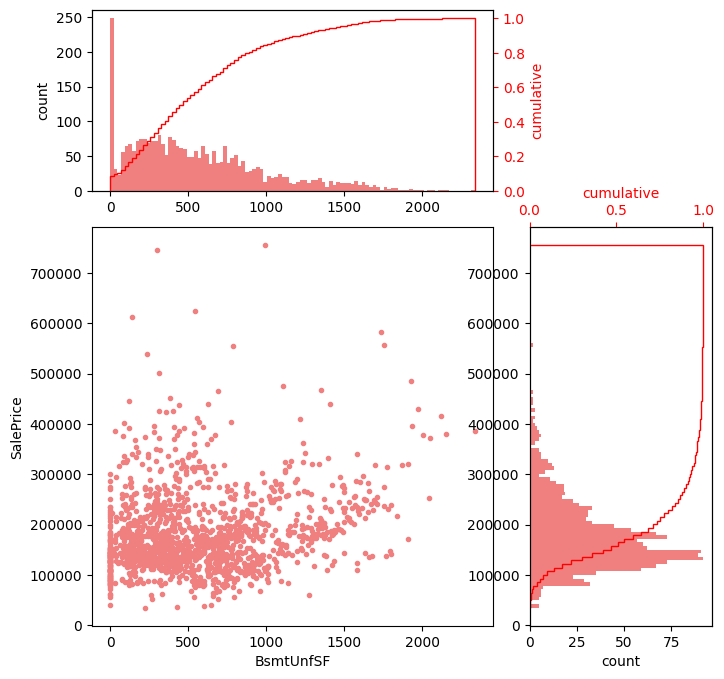

In [ ]:
scatter_hist(all_data, "BsmtUnfSF", "SalePrice")

#### 欠損値の補完

In [ ]:
all_data["BsmtUnfSF"].isna().sum()

1

In [ ]:
# No basementの場合にはBsmtQualがNAとなる。
# 該当の１件はBsmtQualがNaNのため、基礎が存在しない。そのため0で補完するのが妥当といえる
cols = ["Id", "BsmtFinSF1", "BsmtUnfSF"]
all_data[all_data["BsmtUnfSF"].isna()].T

,660
Id,2121
MSSubClass,20
MSZoning,RM
LotFrontage,99.0
LotArea,5940
...,...
MoSold,4
YrSold,2008
SaleType,ConLD
SaleCondition,Abnorml


In [ ]:
cols = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]
all_data[cols].isna().sum()

BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinSF1       1
BsmtFinType2    80
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
dtype: int64

In [ ]:
all_data["BsmtQual"].value_counts()

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

In [ ]:
all_data[all_data["BsmtQual"].isna()].T

,17,39,90,102,156,182,259,342,362,371,...,1118,1139,1242,1303,1306,1343,1344,1364,1431,1444
Id,18,40,91,103,157,183,260,343,363,372,...,2579,2600,2703,2764,2767,2804,2805,2825,2892,2905
MSSubClass,90,90,20,90,20,20,20,90,85,50,...,50,20,90,20,90,20,30,20,30,20
MSZoning,RL,RL,RL,RL,RL,RL,RM,RL,RL,RL,...,RM,RL,RM,RL,RL,RL,RL,RL,C (all),NaN
LotFrontage,72.0,65.0,60.0,64.0,60.0,60.0,70.0,NaN,64.0,80.0,...,64.0,200.0,68.0,86.0,60.0,100.0,55.0,80.0,69.0,125.0
LotArea,10791,6040,7200,7018,7200,9060,12702,8544,7301,17120,...,11067,43500,8927,11650,8544,21370,8250,12048,12366,31250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MoSold,10,6,7,6,6,6,12,5,7,7,...,3,6,8,6,12,6,6,4,10,5
YrSold,2006,2008,2006,2009,2006,2007,2008,2006,2009,2008,...,2007,2007,2006,2006,2006,2006,2006,2006,2006,2006
SaleType,WD,WD,WD,WD,WD,WD,WD,WD,ConLD,WD,...,WD,WD,WD,WD,WD,WD,WD,WD,WD,WD
SaleCondition,Normal,AdjLand,Normal,Alloca,Normal,Normal,Normal,Normal,Normal,Normal,...,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Abnorml,Normal


#### 外れ値の除外

#### 何かいい感じの特徴量を新しく作れないか？
- Totalに対する割合を算出するのがいいかもしれない。

### TotalBsmtSF

#### 分布の確認

#### 欠損値の補完

#### 外れ値の除外

#### 何かいい感じの特徴量を新しく作れないか？

#### 分布の確認

#### 欠損値の補完

#### 外れ値の除外

#### 何かいい感じの組み合わせを作れないか？

### 1stFlrSF

### GrLivArea

### GarageArea

## 分布の確認

#### Target の確認(Dependent, Nominal)

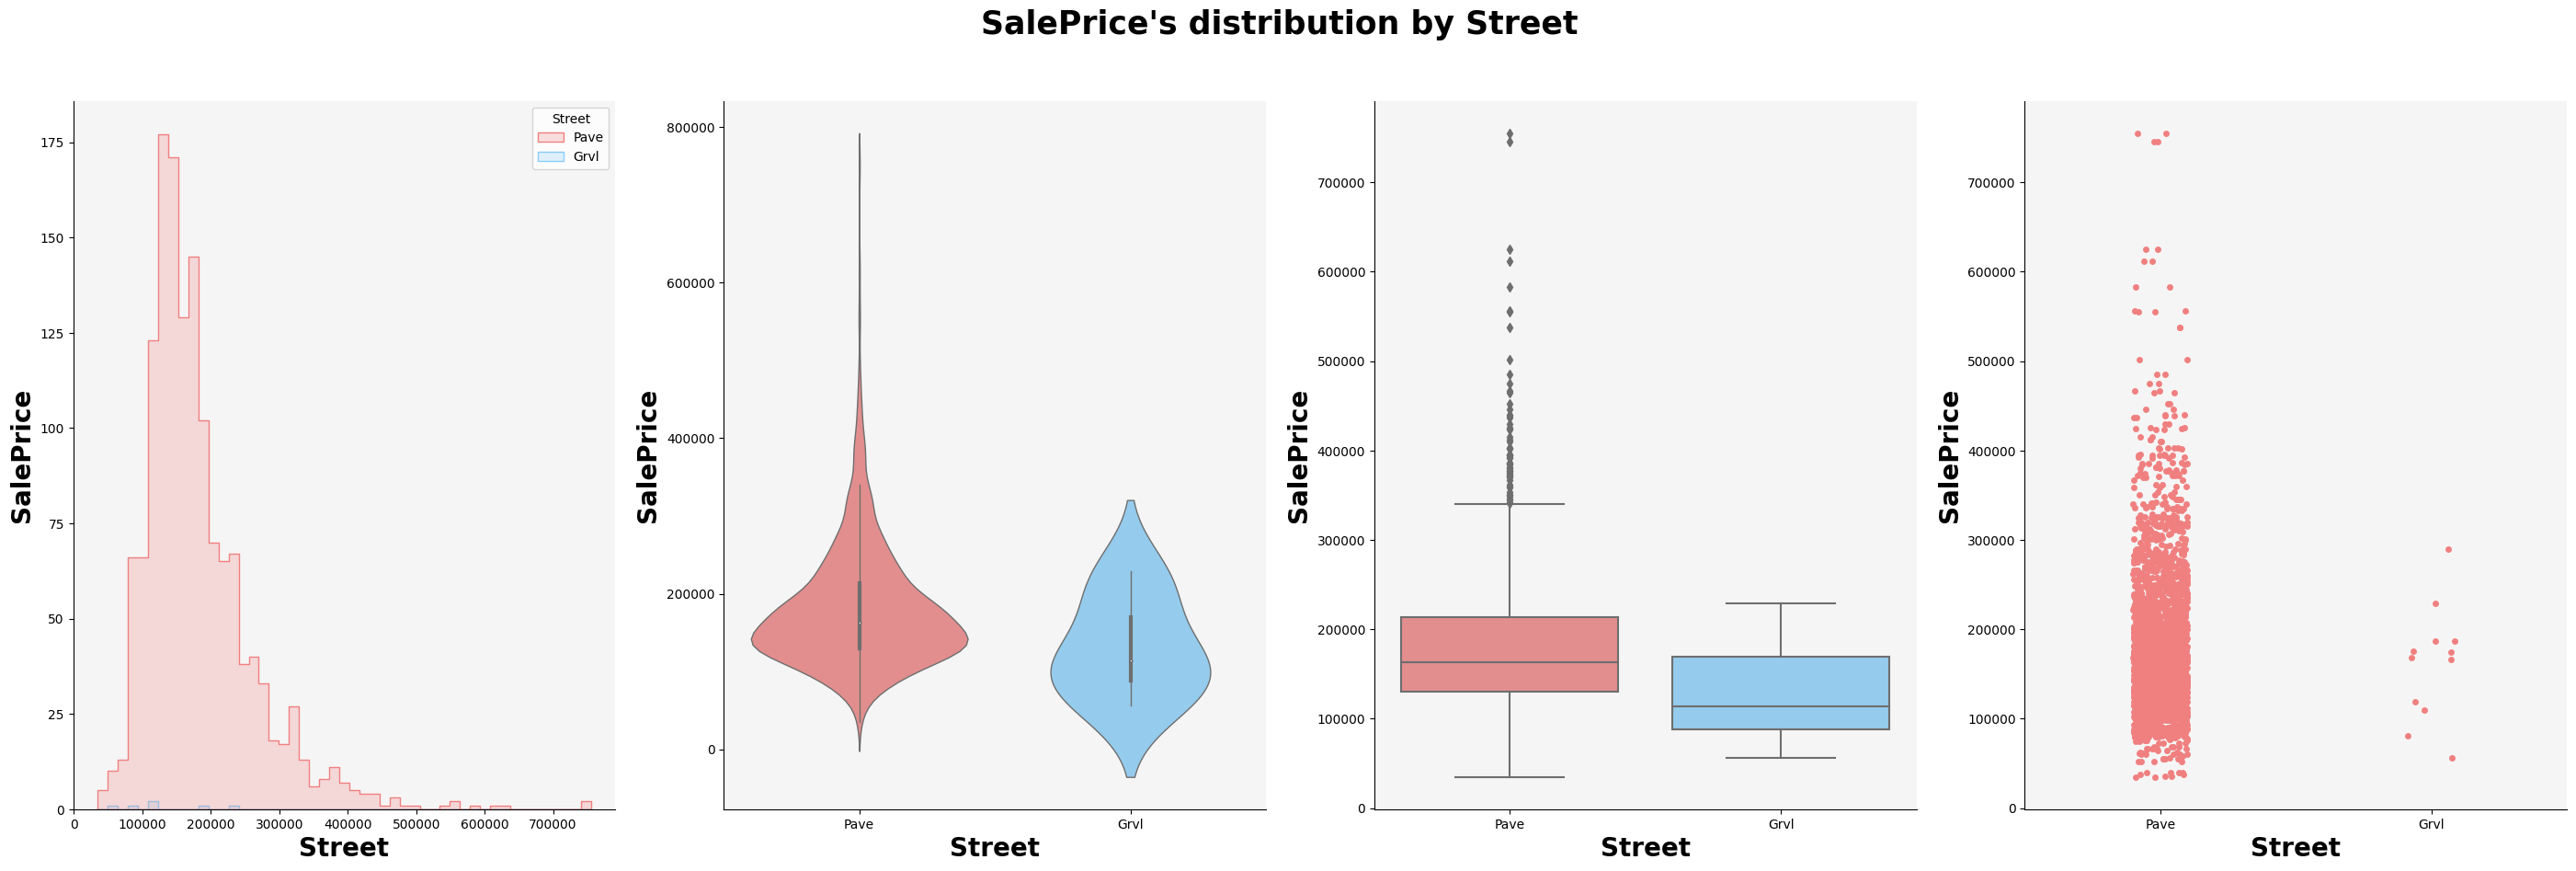

In [ ]:
continuous_dist(all_data, "Street", "SalePrice")

## 新たに特徴量を作る
- 参考：https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition?scriptVersionId=15425540&cellId=51

### Bsmt周りの割合を表すカラムを作成する（効果なし）

In [ ]:
all_data_fe = all_data.copy()

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed["BsmtFinSF1Ratio"] = all_data_preprocessed["skew__BsmtFinSF1"]/all_data_preprocessed["skew__TotalBsmtSF"]
all_data_preprocessed["BsmtFinSF2Ratio"] = all_data_preprocessed["skew__BsmtFinSF2"]/all_data_preprocessed["skew__TotalBsmtSF"]
all_data_preprocessed["BsmtUnfSFRatio"] = all_data_preprocessed["skew__BsmtUnfSF"]/all_data_preprocessed["skew__TotalBsmtSF"]
all_data_preprocessed[target] = list(all_data_fe[target])

In [ ]:
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

Original is better.
Original:-29596.029941591074
New:-29656.04795071597


### 最後に改装もしくは建造されてからの年数（効果あり）




In [ ]:
all_data_fe = all_data.copy()

all_data_fe["YearSinceRemodel"] = all_data_fe["YrSold"] - all_data_fe["YearBuilt"] # ここで新しい特徴量を追加する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])

In [ ]:
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29205.770016765142


### 地下が未完成であることを明示的に表すカラム（若干効果あり）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['BsmtFinType1_Unf'] = 1*(all_data_fe['BsmtFinType1'] == 'Unf') # ここで新しい特徴量を追加する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])

In [ ]:
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29565.356904100237


### WoodDeckを持っていることをを明示的に表すカラム（若干効果あり）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['HasWoodDeck'] = (all_data_fe['WoodDeckSF'] == 0) * 1 # ここで新しい特徴量を追加する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])

In [ ]:
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29595.593231094797


### オープンポーチを持っていることをを明示的に表すカラム（効果なし）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['HasOpenPorch'] = (all_data_fe['OpenPorchSF'] == 0) * 1 # ここで新しい特徴量を追加する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

Original is better.
Original:-29596.029941591074
New:-29597.084277850918


### EnclosedPorchを持っていることをを明示的に表すカラム（効果なし）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['HasEnclosedPorch'] = (all_data_fe['EnclosedPorch'] == 0) * 1 # ここで新しい特徴量を追加する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29596.029941591074


### 3SsnPorchを持っていることをを明示的に表すカラム（効果なし）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['Has3SsnPorch'] = (all_data_fe['3SsnPorch'] == 0) * 1 # ここで新しい特徴量を追加する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29596.029941591074


### 家全体のQualityを表現するカラムを追加（効果あり）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['Total_Home_Quality'] = all_data_fe['OverallQual'] + all_data_fe['OverallCond'] # ここで新しい特徴量を追加する

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29557.67289922975


### トータルの広さ（効果あり）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['TotalSF'] = all_data_fe['TotalBsmtSF'] + all_data_fe['1stFlrSF'] + all_data_fe['2ndFlrSF'] # ここで新しい特徴量を追加する

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29452.477869424525


### 2階があるかどうか（効果あり）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['has2ndfloor'] = all_data_fe['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29596.029941591074


### ガレージがあるかどうか（効果あり）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['hasgarage'] = all_data_fe['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29596.029941591074


### 地下があるかどうか（効果あり）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['hasbsmt'] = all_data_fe['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29596.029941591074


### 暖炉があるかどうか（効果あり）

In [ ]:
all_data_fe = all_data.copy()

all_data_fe['hasfireplace'] = all_data_fe['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29596.029941591074


### 効果のあった特徴量を追加した状態で推論する

In [ ]:
all_data_fe = all_data.copy()

all_data_fe["YearSinceRemodel"] = all_data_fe["YrSold"] - all_data_fe["YearBuilt"] # ここで新しい特徴量を追加する
all_data_fe['BsmtFinType1_Unf'] = 1*(all_data_fe['BsmtFinType1'] == 'Unf') # ここで新しい特徴量を追加する
all_data_fe['HasWoodDeck'] = (all_data_fe['WoodDeckSF'] == 0) * 1 # ここで新しい特徴量を追加する
all_data_fe['Total_Home_Quality'] = all_data_fe['OverallQual'] + all_data_fe['OverallCond'] # ここで新しい特徴量を追加する
all_data_fe['TotalSF'] = all_data_fe['TotalBsmtSF'] + all_data_fe['1stFlrSF'] + all_data_fe['2ndFlrSF'] # ここで新しい特徴量を追加する
all_data_fe['has2ndfloor'] = all_data_fe['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
all_data_fe['hasgarage'] = all_data_fe['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
all_data_fe['hasbsmt'] = all_data_fe['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
all_data_fe['hasfireplace'] = all_data_fe['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-28910.179860921122


### 提出する（Score: 0.1335）

In [ ]:
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
y_pred
output = pd.DataFrame({'Id': test["Id"],
                       'SalePrice': y_pred})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
output

,Id,SalePrice
0,1461,133462.369857
1,1462,154079.305585
2,1463,181497.909950
3,1464,190158.959055
4,1465,179840.880258
...,...,...
1454,2915,77404.277955
1455,2916,82880.606404
1456,2917,156737.604020
1457,2918,125989.201311


## 欠損値処理について、fill_valueをmedianから0に切り替える（効果あり）


In [ ]:
all_data_fe = all_data.copy()

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)

# Preprocessor 周りの工事をする
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy='constant', fill_value=0)), ("scaler", StandardScaler())])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy='constant', fill_value=0)), ("scaler", StandardScaler()), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder())])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-29346.63559448343


## 外れ値に対する処理

### LocalOutlierFactorで外れ値を検出し、SimpleImputer(strategy='mean')で埋める（パラメータによっては効果あり）
- 0.1 ⇒ 悪化
- 0.01 ⇒ 悪化
- 0.001 ⇒ 良くなった

In [ ]:
class CleanOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0, strategy="mean"):
        self.contamination = contamination
        self.strategy = strategy

    def fit(self, X, y=None):
        if self.contamination==0: return self
        self.lof = LocalOutlierFactor(contamination=self.contamination, novelty=True)
        self.lof.fit(X)
        return self

    def transform(self, X_):
        X = deepcopy(X_)
        if self.contamination==0: return X
        idx_outlier = self.lof.predict(X)==-1
        X[idx_outlier, :] = np.nan # set NaN to outlier value

        simple_imputer = SimpleImputer(strategy=self.strategy)
        X = simple_imputer.fit_transform(X) # fill outlier value usin simple_imputer

        return X

In [ ]:
all_data_fe = all_data.copy()
contamination=0.001

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)

# numeric_transformer と skewed_transformerを工事をする
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=contamination, strategy="mean"))])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=contamination, strategy="mean")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder())])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-28337.392353506963


### LocalOutlierFactorで外れ値を検出し、SimpleImputer(strategy='median')で埋める（パラメータによっては効果あり）


In [ ]:
all_data_fe = all_data.copy()
contamination=0.001

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)

# numeric_transformer と skewed_transformerを工事をする
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=contamination, strategy="median"))])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", CleanOutlier(contamination=contamination, strategy="median")), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder())])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-28624.70308192054


### 3 sigma を超えたものを外れ値としてクリッピングする(sigma=4あたりが丁度よさそう）


In [ ]:
class SigmaOutlier(BaseEstimator, TransformerMixin):
    def __init__(self, sigma=3):
        self.sigma = sigma

    def fit(self, X, y=None):
        return self

    def transform(self, X_):
        X = deepcopy(X_)
        X = pd.DataFrame(X)
        for col in X.columns:
          m = np.mean(X[col])
          sd = np.std(X[col])
          X[X[col]>(sd*self.sigma+m)] = m + sd * self.sigma
          X[X[col]<(sd*self.sigma*-1+m)] = m - sd * self.sigma

        return X.to_numpy()

In [ ]:
all_data_fe = all_data.copy()
sigma=4

categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)

# numeric_transformer と skewed_transformerを工事をする
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", SigmaOutlier(sigma=sigma))])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("outlier", SigmaOutlier(sigma=sigma)), ("power", PowerTransformer(method='yeo-johnson'))])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder())])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data_fe[target])
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
new_score = mean(scores["test_score"])

if original_score > new_score:
  print("Original is better.")
else:
  print("New score is better")
print(f"Original:{score_mean}\nNew:{new_score}")

New score is better
Original:-29596.029941591074
New:-28861.934756411065


#### 動作確認（ちゃんと動いている）

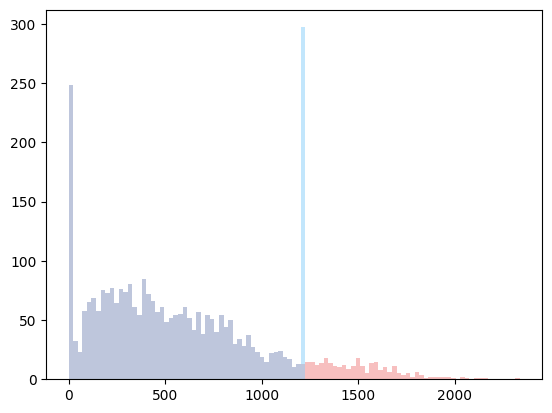

In [ ]:
all_data_fe = all_data.copy()
n_bin = 100
x_max = all_data_fe["BsmtUnfSF"].max()
x_min = all_data_fe["BsmtUnfSF"].min()
bins = np.linspace(x_min, x_max, n_bin)

plt.hist(all_data_fe["BsmtUnfSF"], bins=bins, alpha=0.5)
# plt.show()

outlier = SigmaOutlier(sigma=1.5)
all_data_dealed = outlier.fit_transform(all_data_fe["BsmtUnfSF"])
plt.hist(all_data_dealed, bins=bins, alpha=0.5)
plt.show()

In [ ]:
len(all_data_fe["BsmtUnfSF"])

2919

# 「Regularized Linear Models」を参考に特徴量を作成する
https://www.kaggle.com/code/apapiu/regularized-linear-models

In [ ]:
def get_skewed_column_names(df, numerical_cols, threshold=0.75):
  skewed_feats = df[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
  skewness = pd.DataFrame({'Skew' :skewed_feats})
  skewness = skewness[skewness.abs() > threshold]
  skewness.dropna(inplace=True)
  skewed_features = skewness.index.copy()

  new_numerical_cols = numerical_cols.copy()
  for col in skewed_features:
    new_numerical_cols.remove(col)

  return skewed_features, new_numerical_cols

In [ ]:
def split_data(data, target):
  train_len = data.shape[0]-data[target].isna().sum()
  train_X = data.iloc[:train_len][data.columns.drop(target)]
  train_y = pd.DataFrame(data.iloc[:train_len][target], columns=[target])
  test_X = data.iloc[train_len:][data.columns.drop(target)]

  return train_X, train_y, test_X

In [ ]:
def feature_engineering(data):
  # add new feature
  data["YearSinceRemodel"] = data["YrSold"] - data["YearBuilt"] # ここで新しい特徴量を追加する
  data['BsmtFinType1_Unf'] = 1*(data['BsmtFinType1'] == 'Unf') # ここで新しい特徴量を追加する
  data['HasWoodDeck'] = (data['WoodDeckSF'] == 0) * 1 # ここで新しい特徴量を追加する
  data['Total_Home_Quality'] = data['OverallQual'] + data['OverallCond'] # ここで新しい特徴量を追加する
  data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] # ここで新しい特徴量を追加する
  data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
  data['YrBltAndRemod'] = data['YearBuilt'] + data['YearRemodAdd']
  data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'])
  data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
  data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

  # delete features
  data = data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
  return data

In [ ]:
#Validation function
n_folds = 5

def get_rmse_CV(model, train_X, train_y):
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = cross_validate(model, train_X, train_y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
    rmse = np.sqrt(-scores["test_score"])

    return(rmse)

## 基本コード

In [ ]:
def feature_engineering(data):
  train_len = data.shape[0]-data[target].isna().sum()
  # print(data["SalePrice"][:train_len])
  data["SalePrice"][:train_len] = np.log1p(data["SalePrice"][:train_len])
  # add new feature
  data["YearSinceRemodel"] = data["YrSold"] - data["YearBuilt"] # ここで新しい特徴量を追加する
  data['BsmtFinType1_Unf'] = 1*(data['BsmtFinType1'] == 'Unf') # ここで新しい特徴量を追加する
  data['HasWoodDeck'] = (data['WoodDeckSF'] == 0) * 1 # ここで新しい特徴量を追加する
  data['Total_Home_Quality'] = data['OverallQual'] + data['OverallCond'] # ここで新しい特徴量を追加する
  data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] # ここで新しい特徴量を追加する
  data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # ここで新しい特徴量を追加する
  data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
  data['YrBltAndRemod'] = data['YearBuilt'] + data['YearRemodAdd']
  data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'])
  data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
  data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

  # delete features
  data = data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
  return data

In [ ]:
from sklearn.preprocessing import FunctionTransformer
# FunctionTransformerを用いてnp.log1pを適用するtransformerを作成
log_transformer = FunctionTransformer(np.log1p)

## LGBM

In [ ]:
# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data.copy()

# 特徴量エンジニアリング
all_data_fe =feature_engineering(all_data_fe)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="mean")), ])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="mean")), ("power", log_transformer)])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_lgbm = Pipeline([
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor())
])

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_fe, target)

# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline_lgbm, train_X, train_y)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LGBM score: 0.1343 (0.0172)



In [ ]:
pipeline_lgbm.fit(train_X, train_y)
preds = np.expm1(pipeline_lgbm.predict(test_X))
output = pd.DataFrame({'Id': test["Id"],
                       'SalePrice': preds})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
output

,Id,SalePrice
0,1461,133206.345262
1,1462,157174.596595
2,1463,176519.091957
3,1464,192764.546369
4,1465,184513.846081
...,...,...
1454,2915,79647.142502
1455,2916,76871.370660
1456,2917,161848.908913
1457,2918,108045.471719


## Ridge (Label encoding)

0.13971316173175527

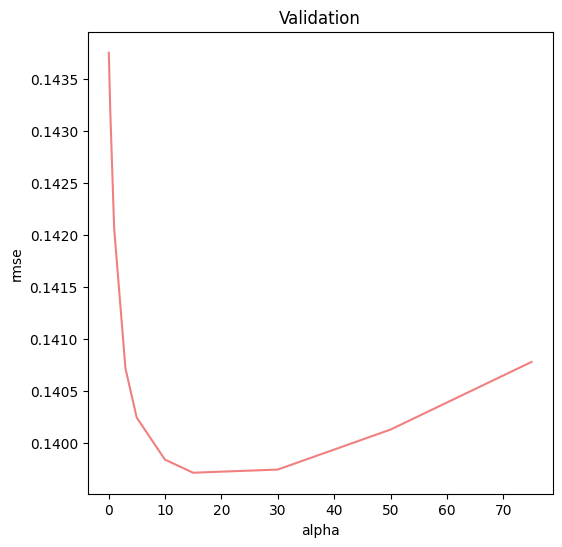

In [ ]:
from sklearn.linear_model import Ridge
# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data.copy()

# 特徴量エンジニアリング
all_data_fe =feature_engineering(all_data_fe)

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_fe, target)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="mean")), ])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="mean")), ("power", log_transformer)])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_ridge = Pipeline([
    ('preprocessing', preprocessor),
    ('model', Ridge())
])

# 作成したPipelineの精度を評価する
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [get_rmse_CV(pipeline_ridge.set_params(model__alpha = alpha), train_X, train_y).mean()
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min()

## Ridge (One-hot encoding)

0.13134265440860876

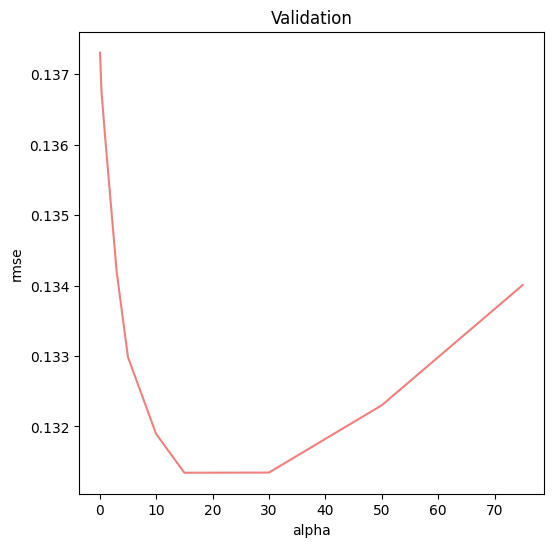

In [ ]:
from sklearn.linear_model import Ridge
# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data.copy()

# 特徴量エンジニアリング
all_data_fe =feature_engineering(all_data_fe)

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_fe, target)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="mean")), ])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="mean")), ("power", log_transformer)])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_ridge = Pipeline([
    ('preprocessing', preprocessor),
    ('model', Ridge())
])

# 作成したPipelineの精度を評価する
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [get_rmse_CV(pipeline_ridge.set_params(model__alpha = alpha), train_X, train_y).mean()
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min()

<Axes: xlabel='preds', ylabel='residuals'>

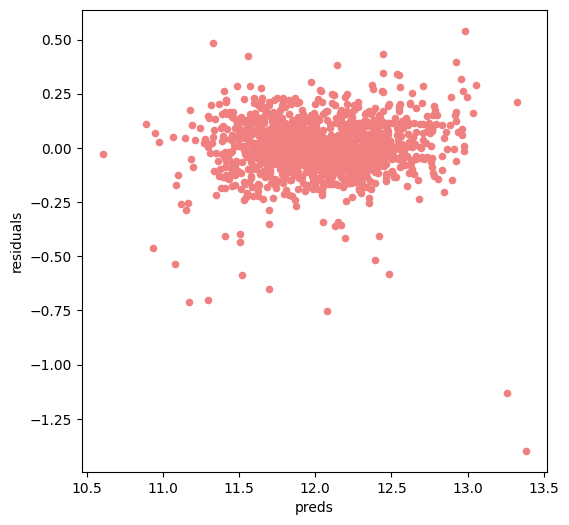

In [ ]:
pipeline_ridge.fit(train_X, train_y)
preds = pipeline_ridge.predict(train_X).ravel() # Added .ravel() to convert the predictions to a 1D array
preds_df = pd.DataFrame({"preds":preds, "true":train_y.values.ravel()}) # Also ensure train_y is a 1D array
preds_df["residuals"] = preds_df["true"] - preds_df["preds"]
preds_df.plot(x = "preds", y = "residuals",kind = "scatter")

## XGboost

In [ ]:
from xgboost import XGBRegressor
# Feature Engineering 用のデータフレームを作る
all_data_fe = all_data.copy()

# 特徴量エンジニアリング
all_data_fe =feature_engineering(all_data_fe)

# 学習用データとテストデータを分ける
train_X, train_y, test_X = split_data(all_data_fe, target)

# 量的変数、カテゴリ変数、歪度のある量的変数を定義する
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, target)
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols, threshold=0.75)

# 特徴量への前処理を行う Preprocessor を定義する
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="mean")), ])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="mean")), ("power", log_transformer)])
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_cols), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

# Pipeline を定義する
pipeline_xgb = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1))
])


# 作成したPipelineの精度を評価する
score = get_rmse_CV(pipeline_xgb, train_X, train_y)
print("XGBT score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

XGBT score: 0.1321 (0.0198)



In [ ]:
pipeline_xgb.fit(train_X, train_y)
pipeline_ridge.fit(train_X, train_y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer())]),
                                                  ['Id', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd',
                                                   'BsmtFullBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr',
                                                   'Fireplaces', 'GarageYrBlt',
                                                   'GarageCars', 'GarageArea',
                                                   'MoSold', 'YrSold',
                                                   'YearSinceRemodel',
                                                   'HasWoodDeck',
                                                   'Total_Home...
       '3SsnPorch', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch',
       'ScreenPorch', 'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF',
       'WoodDeckSF', 'Total_sqr_footage', 'TotalSF', 'LotFrontage', '1stFlrSF',
       'BsmtFinSF1', 'Total_porch_sf', 'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF',
       'BsmtFinType1_Unf', '2ndFlrSF', 'TotRmsAbvGrd', 'hasgarage', 'hasbsmt'],
      dtype='object'))])),
                ('model', Ridge(alpha=75))])

In [ ]:
xgb_preds = np.expm1(pipeline_xgb.predict(test_X))
lasso_preds = np.expm1(pipeline_ridge.predict(test_X))

In [ ]:
list(xgb_preds)

<Axes: xlabel='xgb', ylabel='lasso'>

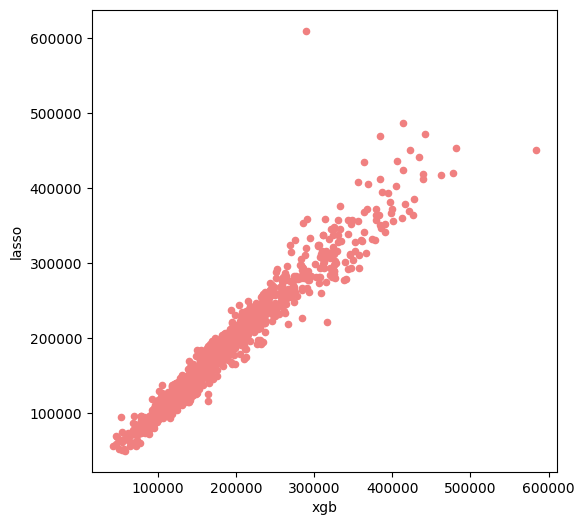

In [ ]:
predictions = pd.DataFrame({"xgb":list(xgb_preds), "lasso":list(lasso_preds)})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [ ]:
preds = 0.7*xgb_preds + 0.3*xgb_preds
# solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
# display(solution)
# solution.to_csv("output.csv", index = False)

output = pd.DataFrame({'Id': test["Id"],
                       'SalePrice': preds})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
output

,Id,SalePrice
0,1461,125149.375000
1,1462,163927.703125
2,1463,181607.343750
3,1464,193061.593750
4,1465,197062.125000
...,...,...
1454,2915,87332.718750
1455,2916,85839.125000
1456,2917,168332.734375
1457,2918,116600.257812


# 以下、実験する用のセルたち

In [ ]:
stop

NameError: ignored

## *** mitty 欠損値処理　***

### 欠損値対象説明変数

- LotArea
- Neighborhood
- YearBuilt
- BsmtFinSF1
- BsmtUnfSF
- TotalBsmtSF
- 1stFlrSF
- GrLivArea
- GarageArea

In [ ]:
all_data_fe = all_data.copy()

In [ ]:
target_col = ['LotArea',
 'Neighborhood',
 'YearBuilt',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'GarageArea']

In [ ]:
all_data_fe[target_col].isnull().sum()

### BSMT系をみる

In [ ]:
for col in all_data_fe.columns[all_data_fe.columns.str.contains("Bsmt")]:
  print(all_data_fe[all_data_fe['BsmtFinSF1'].isnull()][col])

- BsmtSF1の欠損値と同じ行のBsmt系は全て欠損値であることがわかった
- 評価・品質がなし、1以降のBsmtも欠損値であることから、そもそも地下室がないため、featは0として補完することが最も適切

In [ ]:
ext_col = ["BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF"]
all_data_fe[ext_col]

## simple impで欠損値補完

In [ ]:
imp_instant = SimpleImputer(strategy='constant', fill_value=0)
imp_instant.fit(all_data_fe[ext_col])
all_data_fe[ext_col] = pd.DataFrame(imp_instant.transform(all_data_fe[ext_col]), columns = ext_col)

In [ ]:
all_data_fe[target_col].isnull().sum()

## Garage系をみる

In [ ]:
for col in all_data_fe.columns[all_data_fe.columns.str.contains("Garage")]:
  print(all_data_fe[all_data_fe['GarageArea'].isnull()][col])

- Detchd >> Detached from home:家から離れている

- つまり家とは別で契約しているため家の料金には含まれない？
- 他のGarage系も欠損していることから、もともとガレッジは家についていないため、0で補完して良さそう。

- simpl imp 使わずにfillnaをする笑

In [ ]:
all_data_fe['GarageArea'] = all_data_fe['GarageArea'].fillna(0)

In [ ]:
all_data_fe[target_col].isnull().sum()

- これで絞った欠損値は全て補完した

## その他欠損値処理

In [ ]:
imp_zero = SimpleImputer(strategy='constant', fill_value=0)

In [ ]:
categorical_cols, numerical_cols = get_num_cat_column_names(all_data_fe, "SalePrice")
skewed_features, numerical_cols = get_skewed_column_names(all_data_fe, numerical_cols)

## 量的変数は0置換、カテゴリカル変数は評価できないことを意味する値"Unknown"で置換

In [ ]:
# 量的変数の前処理
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy='constant', fill_value=0)), ("scaler", StandardScaler())])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy='constant', fill_value=0)), ("scaler", StandardScaler()), ("power", PowerTransformer(method='yeo-johnson'))])

# カテゴリ変数の前処理
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder())])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

In [ ]:
all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data_fe), columns=get_feature_names(preprocessor))
all_data_preprocessed

### preprocess前とpreprocess後の分布を確認

In [ ]:
all_data_fe[numerical_cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [ ]:
cat_cols_preprocessed = []
num_cols_preprocessed = []
for i in all_data_preprocessed.columns.tolist():
    if all_data_preprocessed[i].dtype=='object':
        cat_cols_preprocessed.append(i)
    else:
        num_cols_preprocessed.append(i)
all_data_preprocessed[num_cols_preprocessed].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

- 正規分布に近い分布に処理されていることが確認できた。

## *** mitty 外れ値処理 ***
- もう手遅れだけど、外れ値 >> pipelineで欠損値処理とBOXCOXをやるべき

In [ ]:
all_data_fe[numerical_cols].describe()

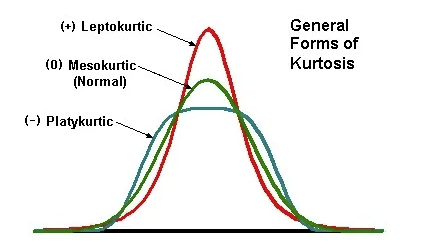
- 尖度は外れ値が存在するかどうかを判定するための尺度となりうる
- 例えば、赤い線の分布よりも、緑の方が平らなため、分布が多い範囲が広くなっているため、3σ以上離れたデータが少ないことを意味する

In [ ]:
kurt_list = []
for col in numerical_cols[1:]:
  print(f"{col} Kurtosis is: " + str(train[col].kurt()))
  if train[col].kurt() > 1:
    kurt_list.append(col)


In [ ]:
train = all_data_fe[all_data_fe["SalePrice"].notnull()]
test = all_data_fe[all_data_fe["SalePrice"].isnull()]
for col in kurt_list:
  train.plot.scatter(x=col, y='SalePrice', ylim=(0,800000));

- カテゴリカル変数も含まれているため消去する

In [ ]:
for col in kurt_list:
  if train[col].nunique() < 20:
    continue
  else:
    train.plot.scatter(x=col, y='SalePrice', ylim=(0,800000));

In [ ]:
train_y["SalePrice"] = np.log1p(train_y["SalePrice"])
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv = KFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor(objective='regression', num_leaves=4,learning_rate=0.01, n_estimators=6000,
                          max_bin=200, bagging_fraction=0.75,bagging_freq=5, bagging_seed=7,
                          feature_fraction=0.2,feature_fraction_seed=7,verbose=-1)
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
score_mean = mean(scores["test_score"])
print(f"score:{score_mean}")

score:-0.0003848333939184409


## optuna チューニング

In [ ]:
#tuning hyper parameter of a base model
#we take Kernel Ridge as the base model, then use grid search to find the best hyper parameters
!pip install optuna
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# データをトレーニング用と検証用に分割
train_y["SalePrice"] = np.log1p(train_y["SalePrice"])
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
eval_set = [(X_valid, y_valid)]

import optuna
# ベイズ最適化時の評価指標算出メソッド
# 学習時fitパラメータ指定


def calculate_rmse(predictions, targets):
    """
    RMSEを計算する関数

    Parameters:
        predictions (numpy.ndarray): 予測値のNumPy配列
        targets (numpy.ndarray): 実際の値のNumPy配列

    Returns:
        float: RMSEの値
    """

    targets = targets.values
    # 予測値と実際の値の差を計算
    errors = predictions - targets

    # 差の2乗を計算して平均を取る
    squared_errors = errors ** 2
    mean_squared_error = squared_errors.mean()

    # 平均二乗誤差（MSE）を取り、ルートを計算してRMSEを得る
    rmse = np.sqrt(mean_squared_error)
    return -rmse

def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0000, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0000, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 20),
        'bagging_fraction':trial.suggest_float('bagging_fraction',0.1, 21),
        'max_bin': trial.suggest_int('max_bin',10, 101),
        'feature_fraction':trial.suggest_int('feature_fraction',0.1, 21),
        'num_leaves':trial.suggest_int('num_leaves',1, 21),
        "feature_fraction_seed": trial.suggest_int('feature_fraction_seed', 1, 21),
        "bagging_freq":trial.suggest_int('bagging_freq',1, 21)
        }
    # モデルにパラメータ適用


    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = calculate_rmse(y_pred, y_valid)
    print(score)
    # predict with validation data

    # convert to bool with threshold is 0.5


    return score
study_name = "230729_test_neg"
db_name = 'sqlite:///230729_optuna.db'

# ベイズ最適化を実行
study = optuna.create_study(study_name = study_name, direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=500), storage=db_name, load_if_exists = True)
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')


## パラメータを変化させた時の予測性能変化をプロットする


## get_rmse_CV関数定義

In [34]:
#Validation function
n_folds = 5

def get_rmse_CV(model, train_X, train_y):
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = cross_validate(model, train_X, train_y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
    rmse = np.sqrt(-scores["test_score"])

    return(rmse)

In [ ]:
parameters = {'bagging_fraction':[i / 10 for i in range(1, 21)],
              'max_bin': [i for i in range(0, 101, 10)],
              'feature_fraction':[i / 10 for i in range(1, 21)],
              'num_leaves':[i for i in range(1, 21)],
              "feature_fraction_seed": [i for i in range(1, 21)],
              "bagging_freq":[i for i in range(1, 21)],
              }

In [54]:
bagging_fraction

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [77]:
train_y["SalePrice"] = np.log1p(train_y["SalePrice"])
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=1)

def calculate_rmse(predictions, targets):
    # print(targets)
    # print(predictions)
    targets = targets
    # 予測値と実際の値の差を計算
    errors = predictions.values - targets

    # 差の2乗を計算して平均を取る
    squared_errors = errors ** 2
    mean_squared_error = squared_errors.mean()

    # 平均二乗誤差（MSE）を取り、ルートを計算してRMSEを得る
    rmse = np.sqrt(mean_squared_error)
    return rmse


def view_ch_para(para_list, param_name):


  result = []
  # アーリーストッピングを考慮した交差検証を実行
  for i in para_list:

    params = {
            'objective': 'regression',
            'learning_rate': 0.01,
            'n_estimators': 6000,
            param_name: i
        }
    model = lgb.LGBMRegressor(**params)
    X_train_part, X_valid_part, y_train_part, y_valid_part = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    # Train the model with early stopping
    model.fit(
        X_train_part, y_train_part,
        eval_set=[(X_valid_part, y_valid_part)],
        eval_metric='rmse',
        early_stopping_rounds=100,  # Number of rounds to wait for the metric to improve
        verbose=-1  # Print evaluation results every 100 rounds
    )
  # 各分割に対して交差検証を行うループ
    scores = []
    for train_index, valid_index in cv.split(X_train, y_train):
        X_train_part, X_valid_part = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_part, y_valid_part = y_train.iloc[train_index], y_train.iloc[valid_index]

        # 学習データでモデルを学習
        model.fit(
            X_train_part, y_train_part,
            eval_set=[(X_valid_part, y_valid_part)],
            eval_metric='rmse',
            early_stopping_rounds=100,
            verbose=100
        )

        # 検証データでの予測結果を取得
        y_pred_valid = model.predict(X_valid_part, num_iteration=model.best_iteration_)

        # RMSEを計算してスコアリストに追加
        score_mean = calculate_rmse(y_valid_part, y_pred_valid)
        scores.append(score_mean)

    # 各分割のスコアの平均を計算
    score_mean = np.mean(scores)
    print(f"{param_name}: {i}, mean RMSE: {score_mean}")
    result.append([i, score_mean])
  result_df = pd.DataFrame(result)
  x = result_df[0]
  y = result_df[1]
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(x, y,marker="o")
  ax.set_title(param_name)
  plt.show()

In [72]:
max_bin

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

## max_bin

[100]	valid_0's rmse: 6.43486e-05	valid_0's l2: 4.14074e-09
[200]	valid_0's rmse: 4.74029e-05	valid_0's l2: 2.24704e-09
[300]	valid_0's rmse: 3.98562e-05	valid_0's l2: 1.58852e-09
[400]	valid_0's rmse: 3.60965e-05	valid_0's l2: 1.30296e-09
[500]	valid_0's rmse: 3.42261e-05	valid_0's l2: 1.17142e-09
[600]	valid_0's rmse: 3.2916e-05	valid_0's l2: 1.08346e-09
[700]	valid_0's rmse: 3.20925e-05	valid_0's l2: 1.02993e-09
[800]	valid_0's rmse: 3.12156e-05	valid_0's l2: 9.74413e-10
[900]	valid_0's rmse: 3.07076e-05	valid_0's l2: 9.42958e-10
[1000]	valid_0's rmse: 3.03877e-05	valid_0's l2: 9.23411e-10
[1100]	valid_0's rmse: 3.00786e-05	valid_0's l2: 9.04723e-10
[1200]	valid_0's rmse: 2.99202e-05	valid_0's l2: 8.9522e-10
[1300]	valid_0's rmse: 2.98167e-05	valid_0's l2: 8.89033e-10
[1400]	valid_0's rmse: 2.98128e-05	valid_0's l2: 8.88803e-10
[1500]	valid_0's rmse: 2.97694e-05	valid_0's l2: 8.86215e-10
[1600]	valid_0's rmse: 2.97419e-05	valid_0's l2: 8.8458e-10
[100]	valid_0's rmse: 7.20321e-05	va

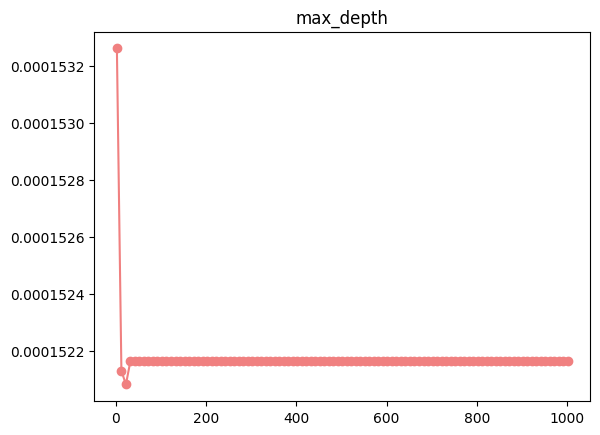

In [78]:

max_depth = [i for i in range(2, 1010, 10)]
view_ch_para(max_bin, "max_depth")

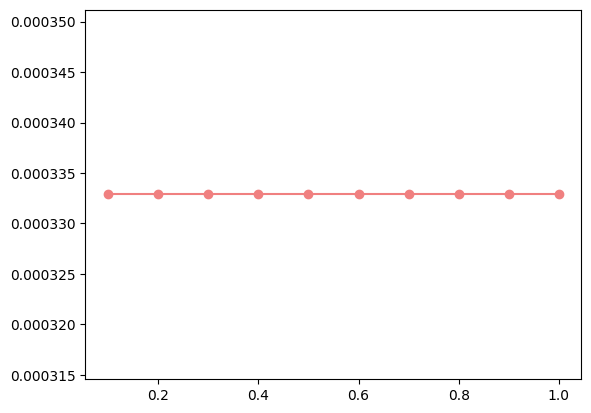

In [60]:
result_df = pd.DataFrame(result)
x = result_df[0]
y = result_df[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y,marker="o")
plt.show()